In [11]:
#!pip install numpy==1.19.5

In [12]:
#importing libraries 
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D, GlobalAveragePooling2D,Reshape
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")
#!pip install visualkeras

In [13]:
#function to load datasetfile
def dataframe_creation():
    df4 = pd.read_csv('./full_df.csv')
    df4['filename']='./preprocessed_images/'+df4['filename']
    df4['Left-Fundus']='./preprocessed_images/'+df4['Left-Fundus']
    df4['Right-Fundus']='./preprocessed_images/'+df4['Right-Fundus']
    df4['Line'] = df4['Left-Diagnostic Keywords']+' | '+df4['Right-Diagnostic Keywords']
    df4 = df4.drop(['filepath','target'], axis=1)
    return df4
df = dataframe_creation()
print(df.shape)
df.head()

(6392, 18)


ID  Patient Age Patient Sex                       Left-Fundus  \
0   0           69      Female  ./preprocessed_images/0_left.jpg   
1   1           57        Male  ./preprocessed_images/1_left.jpg   
2   2           42        Male  ./preprocessed_images/2_left.jpg   
3   4           53        Male  ./preprocessed_images/4_left.jpg   
4   5           50      Female  ./preprocessed_images/5_left.jpg   

                        Right-Fundus  \
0  ./preprocessed_images/0_right.jpg   
1  ./preprocessed_images/1_right.jpg   
2  ./preprocessed_images/2_right.jpg   
3  ./preprocessed_images/4_right.jpg   
4  ./preprocessed_images/5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O labels  \
0                           normal fundus  0  0  0  1  0  0  0  0  ['N']   
1                           normal fundus  1  0  0  0  0  0  0  0  ['N']   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  ['D']   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  ['D']   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0  ['D']   

                            filename  \
0  ./preprocessed_images/0_right.jpg   
1  ./preprocessed_images/1_right.jpg   
2  ./preprocessed_images/2_right.jpg   
3  ./preprocessed_images/4_right.jpg   
4  ./preprocessed_images/5_right.jpg   

                                                Line  
0                           cataract | normal fundus  
1                      normal fundus | normal fundus  
2  laser spot，moderate non proliferative retinopa...  
3  macular epiretinal membrane | mild nonprolifer...  
4  moderate non proliferative retinopathy | moder...

In [14]:
df['Patient Sex'].unique()

array(['Female', 'Male'], dtype=object)

# Visualize Data

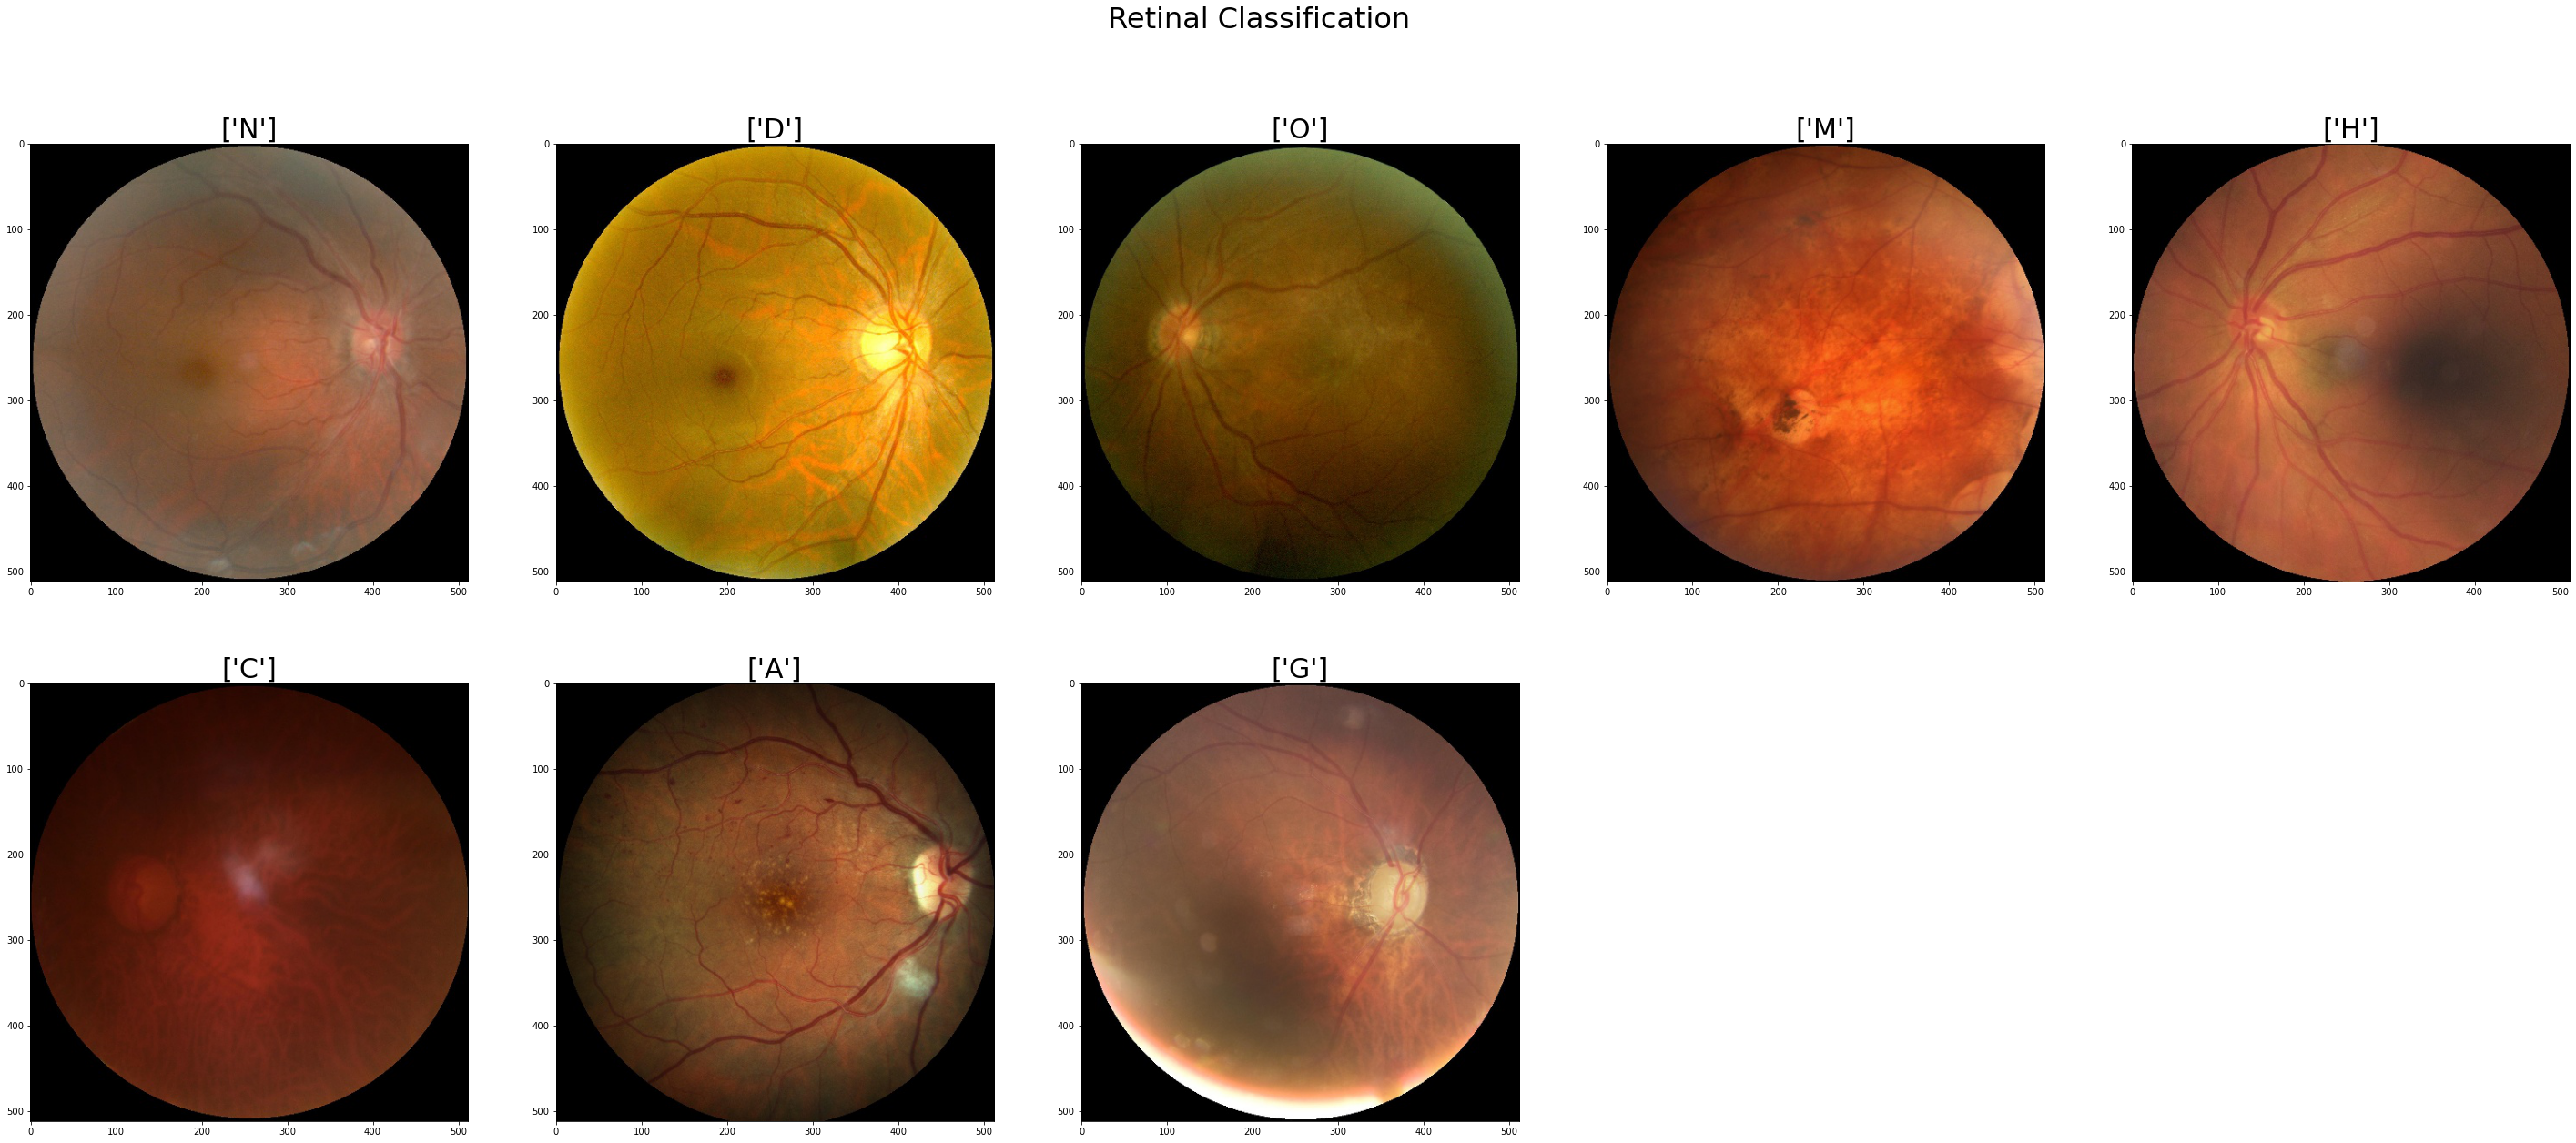

In [15]:
#Loading sample images from various classes
count = 1
f = plt.figure(figsize=(50,20))
for Class in df['labels'].unique():
    seg = df[df['labels']==Class]
    address = seg.sample().iloc[0]['filename']
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print(img)
    ax = f.add_subplot(2, 5,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Retinal Classification", size = 32)
plt.show()

In [16]:
#settign height and width for images
w , h= 32,32
final_class = 8

## Data Cleaning

In [17]:
# finding records where both left and right eye images do not exist
listImg = os.listdir('./preprocessed_images')
string = './preprocessed_images/'
list2 = list(map(lambda orig_string: string + orig_string , listImg))
indexify =[]
for i in df.index:
    if df.iloc[i]['Left-Fundus'] in list2 and df.iloc[i]['Right-Fundus'] in list2:
        continue
    else:
        indexify.append(i)

In [18]:
# removing records where both left and right eye images do not exist
print(df.shape)
df = df.drop(indexify)
print(df.shape)
df.reset_index(inplace= True)

(6392, 18)
(6068, 18)


In [19]:
# finding duplicate paitent entries 
existing =[]
indexify =[]
for i in df.index:    
    if df.iloc[i]['ID'] in existing:
        indexify.append(i)
    else:
        existing.append(df.iloc[i]['ID'])
    

In [20]:
#deleting duplciate entries
print(df.shape)
df = df.drop(indexify)
print(df.shape)
df.reset_index(inplace= True)

(6068, 19)
(3034, 19)


In [21]:
# changing color space of images and applying interpolation to preserve image quality
# and storing let and right images in X1 and X2 array respectively 
from tqdm import tqdm
left = []
index=0
for location in tqdm(df.iloc[:]['Left-Fundus']):
    img = cv2.imread(location)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    #img = img.reshape(w,h,1)   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    left.append(img)
    index = index +1
right = []
for location in tqdm(df.iloc[:]['Right-Fundus']):
    img = cv2.imread(location)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    #img = img.reshape(w,h,1)
    right.append(img)
X1 = np.array(left)
X2 = np.array(right)

100%|██████████| 3034/3034 [00:18<00:00, 160.86it/s]


In [22]:
# building target variable 'y' by combining  binary label columns

from sklearn.preprocessing import OneHotEncoder
y = np.array(df.iloc[:][['N','D','G','C','A','H','M','O']])
y = np.array(y)
print('Label :   '+str(y.shape))

Label :   (3034, 8)


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
# function to reduce learning rate when validation loss becomes stagnant
def get_LR_checkpoint(lr_factor=0.2,lr_patience=4,lr_min=0.00001):
    return ReduceLROnPlateau(monitor='val_loss',factor=lr_factor,verbose=1,patience=lr_patience,min_lr=lr_min)
# function to store model 
def get_model_checkpoint():
    checkpoint = ModelCheckpoint('resnet_bilstm15Novsigmoid0.3.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
    return checkpoint
# callback function combining both the above functions to be used during model training
def get_callbacks(lr_factor=0.2,lr_patience=4,lr_min=0.00001):
    checkpoint= get_model_checkpoint()
    LR= get_LR_checkpoint(lr_factor,lr_patience,lr_min)
    callbacks_list = [checkpoint, LR]
    return callbacks_list

In [24]:
# creating the model
def model_b():
    inp1 = Input(shape=(X1.shape[1],X1.shape[2],3,))
    inp2 = Input(shape=(X2.shape[1],X2.shape[2],3,))
    new_input = Input(shape=(X1.shape[1],X1.shape[2], 3))
    conv1 = Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp1)
    m1 = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=new_input,
                        input_shape=None,
                         pooling='avg',
                    )
    m1.trainable=False 
    i1 = m1(conv1)
    conv2= Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp2)
    m2 = tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_tensor=new_input,
                        input_shape=None,
                         pooling='avg',
                    
                    )
    m2.trainable=False 
    i2=m2(conv2)
    merge = concatenate([i1,i2])
    class1 = Reshape(target_shape= (1,merge.shape[1]))(merge)    
   
    class1 = Bidirectional (LSTM(1024,  dropout=0.1))(class1)
    
    output = Dense(final_class, activation='sigmoid')(class1)
    model = Model(inputs=[inp1,inp2], outputs=output)
    return model
md = model_b()

In [25]:
md.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 3)    84          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 3)    84          input_2[0][0]                    
______________________________________________________________________________________________

# Train Test Splitting

In [26]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(X1,X2, y, test_size=0.20, random_state=42)

In [27]:
X_train1, X_valid1, X_train2, X_valid2, y_train, y_valid = train_test_split(X_train1,X_train2, y_train, test_size=0.20, random_state=42)

In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
# function to train model
def LR_verify():
        model = model_b()
        METRICS = [
                'accuracy'
        ]  
        model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
        history = model.fit([X_train1,X_train2], y_train, epochs=150,verbose=1,shuffle = True, validation_data=([X_valid1,X_valid2],y_valid),batch_size=104,callbacks=get_callbacks())
        return model,history
#training the model    
model,history= LR_verify()

Epoch 1/150
19/19 [==============================] - 121s 6s/step - loss: 0.4585 - accuracy: 0.3104 - val_loss: 0.3576 - val_accuracy: 0.3395

Epoch 00001: val_loss improved from inf to 0.35762, saving model to resnet_bilstm15Novsigmoid0.3.hdf5
Epoch 2/150
19/19 [==============================] - 2s 93ms/step - loss: 0.3406 - accuracy: 0.4025 - val_loss: 0.3495 - val_accuracy: 0.3765

Epoch 00002: val_loss improved from 0.35762 to 0.34952, saving model to resnet_bilstm15Novsigmoid0.3.hdf5
Epoch 3/150
19/19 [==============================] - 2s 92ms/step - loss: 0.3398 - accuracy: 0.4132 - val_loss: 0.3471 - val_accuracy: 0.3868

Epoch 00003: val_loss improved from 0.34952 to 0.34710, saving model to resnet_bilstm15Novsigmoid0.3.hdf5
Epoch 4/150
19/19 [==============================] - 2s 92ms/step - loss: 0.3275 - accuracy: 0.4224 - val_loss: 0.3427 - val_accuracy: 0.3807

Epoch 00004: val_loss improved from 0.34710 to 0.34270, saving model to resnet_bilstm15Novsigmoid0.3.hdf5
Epoch 5/

In [30]:
# visualise accuracy during training 
def plot_history_acc(history):    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc="lower right")
    plt.show() 

# visualise loss during training
def plot_history_loss(history):    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc="lower right")
    plt.show()   
   
# plot confusion matrix
def plotConfuxionMatrix(disease, cm):    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title(f' Confusion Matrix for Label: {disease}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()  

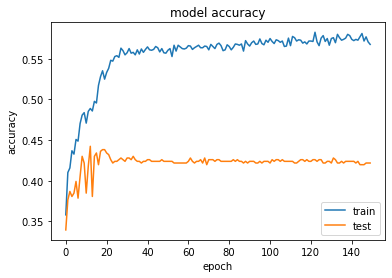

In [31]:
plot_history_acc(history)

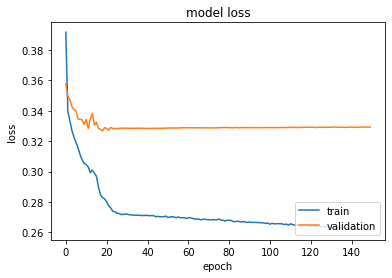

In [32]:
plot_history_loss(history)

In [33]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.tail()

loss  accuracy  val_loss  val_accuracy       lr
145  0.261792  0.581144  0.329242      0.419753  0.00001
146  0.262218  0.571870  0.329231      0.419753  0.00001
147  0.261954  0.577022  0.329180      0.421811  0.00001
148  0.261570  0.570840  0.329179      0.421811  0.00001
149  0.261724  0.567749  0.329217      0.421811  0.00001

In [34]:
loaded_model = model

# Results

## Model perfomance on validation set

In [35]:
METRICS = [
                'accuracy',
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.TruePositives()
        ]  
loaded_model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([X_valid1,X_valid2], y_valid, verbose=0)

In [36]:
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.32921653985977173
accuracy : 0.42181068658828735
false_negatives : 479.0
false_positives : 98.0
precision : 0.47311827540397644
recall : 0.15520282089710236
true_negatives : 3223.0
true_positives : 88.0


## Model perfomance on Test set

In [37]:
METRICS = [
                'accuracy',
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.TruePositives()
        ]  
loaded_model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([X_test1,X_test2], y_test, verbose=0)

In [38]:
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.31366634368896484
accuracy : 0.44481053948402405
false_negatives_1 : 556.0
false_positives_1 : 132.0
precision_1 : 0.5129151344299316
recall_1 : 0.20000000298023224
true_negatives_1 : 4029.0
true_positives_1 : 139.0


In [39]:
#printing multilabel classification report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import pandas as pd
yhat = loaded_model.predict([X_test1,X_test2])
yhat = yhat.round()
report = classification_report(y_test, yhat,target_names=['N','D','G','C','A','H','M','O'],output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
N              0.444444  0.162437  0.237918    197.0
D              0.480263  0.350962  0.405556    208.0
G              0.000000  0.000000  0.000000     33.0
C              0.647059  0.261905  0.372881     42.0
A              0.000000  0.000000  0.000000     32.0
H              0.000000  0.000000  0.000000     24.0
M              0.821429  0.766667  0.793103     30.0
O              0.000000  0.000000  0.000000    129.0
micro avg      0.512915  0.200000  0.287785    695.0
macro avg      0.299149  0.192746  0.226182    695.0
weighted avg   0.344273  0.200000  0.245582    695.0
samples avg    0.228995  0.207578  0.214717    695.0

In [40]:
# printing multilabel confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_test, yhat)
print(cm)

[[[370  40]
  [165  32]]

 [[320  79]
  [135  73]]

 [[573   1]
  [ 33   0]]

 [[559   6]
  [ 31  11]]

 [[575   0]
  [ 32   0]]

 [[583   0]
  [ 24   0]]

 [[572   5]
  [  7  23]]

 [[477   1]
  [129   0]]]


### Plotting confusion matrix

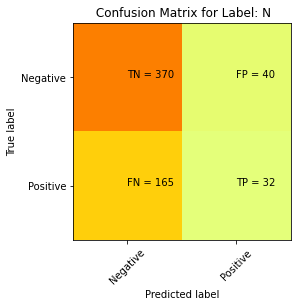

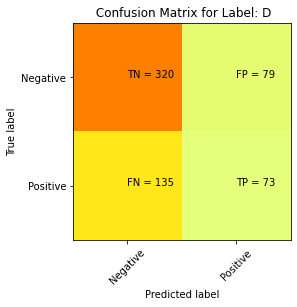

In [41]:
plotConfuxionMatrix('N', cm[0])
plotConfuxionMatrix('D', cm[1])

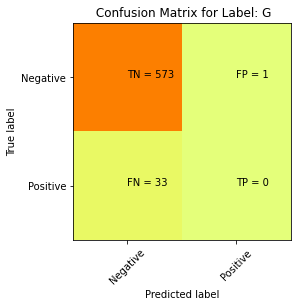

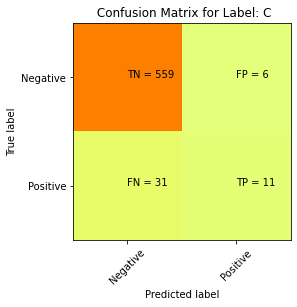

In [42]:
plotConfuxionMatrix('G', cm[2])
plotConfuxionMatrix('C', cm[3])


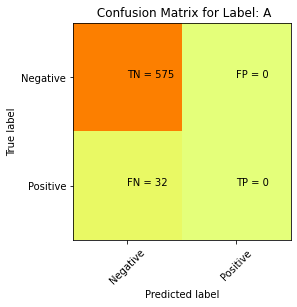

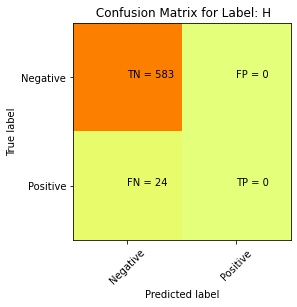

In [43]:
plotConfuxionMatrix('A', cm[4])
plotConfuxionMatrix('H', cm[5])

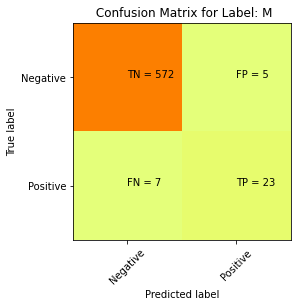

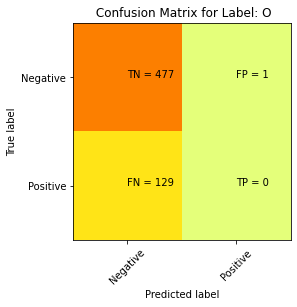

In [44]:
plotConfuxionMatrix('M', cm[6])
plotConfuxionMatrix('O', cm[7])